# Brain Metastasis Classification - EDA

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
from monai.transforms import LoadImage

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# 🧪 Dataset Overview 
This notebook provides an initial, structured overview of the dataset.  
The goal is to review the class distribution to detect potential class imbalance
and to visualize representative images. 

In [15]:
# Load labels
data_path = Path('Dataset/train')
labels_df = pd.read_csv(data_path / 'labels1.csv')
cts_path = data_path / 'CTs'

print(f"Number of patients: {labels_df.shape[0]}")
print(f"First few rows:")
print(labels_df.head())

Number of patients: 5122
First few rows:
   Unnamed: 0            ID  Label
0         187  ID_0a013ee77      0
1         402  ID_0a0f3abd0      0
2         528  ID_0a546826c      0
3         610  ID_0b3361e8f      0
4         778  ID_0be6bcde8      0


# 📊 Class Distribution Analysis

This section summarizes the distribution of samples across the two classes,
including both absolute counts and relative percentages, and provides a visual
representation to assess potential class imbalance.

Class Distribution:
Class 0 (No metastasis): 4843 samples (94.55%)
Class 1 (Metastasis):    279 samples (5.45%)


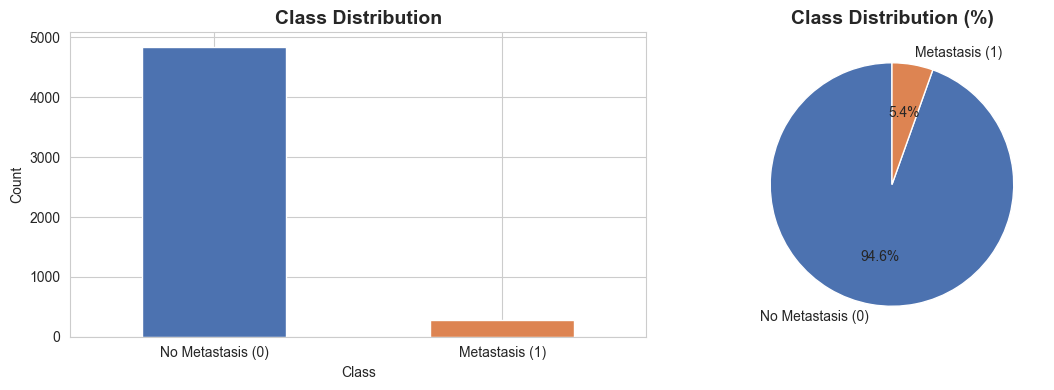

In [16]:
# Class distribution
class_counts = labels_df['Label'].value_counts()
class_percentages = labels_df['Label'].value_counts(normalize=True) * 100

print("Class Distribution:")
print(f"Class 0 (No metastasis): {class_counts.loc[0]} samples ({class_percentages.loc[0]:.2f}%)")
print(f"Class 1 (Metastasis):    {class_counts.loc[1]} samples ({class_percentages.loc[1]:.2f}%)")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Bar plot
class_counts.plot(kind='bar', ax=axes[0], color=['#4C72B0', '#DD8452'])
axes[0].set_title('Class Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['No Metastasis (0)', 'Metastasis (1)'], rotation=0)

# Pie chart
axes[1].pie(class_counts, labels=['No Metastasis (0)', 'Metastasis (1)'], 
            autopct='%1.1f%%', colors=['#4C72B0', '#DD8452'], startangle=90)
axes[1].set_title('Class Distribution (%)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# 🖼️ Representative CT Samples per Class

This section presents randomly selected CT scans from each class
to provide a qualitative visual inspection of the data.

Three samples with metastasis and three samples without metastasis are displayed,
allowing assessment of image quality, anatomical variability, and potential
visual differences between classes.

In [ ]:
# Set random seed for reproducibility
np.random.seed(42)

# Get random samples from each class
class_0_ids = labels_df[labels_df['Label'] == 0]['ID'].values
class_1_ids = labels_df[labels_df['Label'] == 1]['ID'].values

# Randomly select 3 samples from each class
selected_ids_0 = np.random.choice(class_0_ids, size=3, replace=False)
selected_ids_1 = np.random.choice(class_1_ids, size=3, replace=False)

# Get all DICOM files
dicom_files = list(cts_path.rglob('*.dcm'))

# MONAI loader for visualization
# LoadImage automatically:
# 1. Reads DICOM files
# 2. Converts to Hounsfield Units (HU) using RescaleSlope/RescaleIntercept
# 3. Applies orientation standardization (same as training pipeline)
loader = LoadImage(image_only=True)

def apply_window(img, window_center, window_width):
    """Applying standard brain windowing (Contrast)"""
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    windowed_img = np.clip(img, img_min, img_max)
    return windowed_img

# window center and width for visual
WINDOW_CENTER = 40 
WINDOW_WIDTH = 80

# plotting
fig, axes = plt.subplots(2, 3, figsize=(20, 16))

# Add row label for positive class (above the row)
fig.text(0.5, 0.92, 'Label 1 (Metastasis)', fontsize=20, fontweight='bold', 
         ha='center', va='bottom', color='black')

# pos class
for idx, sample_id in enumerate(selected_ids_1):
    matching_files = [f for f in dicom_files if sample_id in f.name]
    if matching_files:
        # Load with MONAI (same as training pipeline)
        hu_img = loader(str(matching_files[0]))
        brain_img = apply_window(hu_img, WINDOW_CENTER, WINDOW_WIDTH)
        
        axes[0, idx].imshow(brain_img, cmap='gray')
        axes[0, idx].axis('off')

# Add row label for negative class (above the row)
fig.text(0.5, 0.48, 'Label 0 (Normal)', fontsize=20, fontweight='bold', 
         ha='center', va='bottom', color='black')

# neg class
for idx, sample_id in enumerate(selected_ids_0):
    matching_files = [f for f in dicom_files if sample_id in f.name]
    if matching_files:
        # Load with MONAI (same as training pipeline)
        hu_img = loader(str(matching_files[0]))
        brain_img = apply_window(hu_img, WINDOW_CENTER, WINDOW_WIDTH)
        
        axes[1, idx].imshow(brain_img, cmap='gray')
        axes[1, idx].axis('off')

plt.suptitle('Brain CT with Clinical Windowing (Center:40, Width:80)', 
             fontsize=22, fontweight='bold', y=0.99)
plt.tight_layout()
plt.show()